# Extração de características (LBP e HOG) — Projeto Cat vs Dog
Notebook preparado para Google Colab.
Objetivo: gerar **bases CSV** com as features extraídas das imagens (LBP e HOG)
usando os parâmetros exigidos:
- **LBP**: resolução 256x256, radius = 3, 6, 12 (n_points = 8 * radius, método 'uniform'), variando:
  - lbp_methods = ['uniform', 'ror'] → métodos LBP padrão e,
  - multi_orientation_angles = [0, 45, 90, 135] → ângulos usados para LBP multi-orientation.

- **HOG**: resolução 256x256 e 128x128; pixels_per_cell = (32,32), (16,16), (8,8);
       orientations = 9 (padrão); cells_per_block = (2,2)
       Aplicar PCA para manter **90%** e **75%** da variância (gerar CSVs para cada).
Rotina salva todos os CSVs em pasta de saída no Google Drive.


#2) Montar Drive e definir caminhos (Código)

In [ ]:
# -------------- Montar Drive ---------------
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

# --- Defina o caminho fornecido por você (já com a pasta que contém as imagens) ---
caminho = "/content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/cats&dogs"

# Pasta onde os CSVs serão salvos (uma só pasta)
output_dir = os.path.join(os.path.dirname(caminho), "features_output")
os.makedirs(output_dir, exist_ok=True)

print("Pasta de imagens:", caminho)
print("Pasta de saída (CSVs):", output_dir)


Mounted at /content/drive
Pasta de imagens: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/cats&dogs
Pasta de saída (CSVs): /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output


#3) Importações e funções utilitárias (Código)

In [ ]:
# -------------- Importações --------------
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import local_binary_pattern, hog
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

# extensões de imagem aceitas
IMG_EXTS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

# --- Função para checar se é imagem ---
def is_image_file(fname):
    return fname.lower().endswith(IMG_EXTS)

# --- Parser de rótulos pelo nome do arquivo (case-insensitive) ---
def parse_labels_from_filename(fname):
    # detecta a raça baseada nos substrings comuns
    fname_low = fname.lower()
    if 'siamese' in fname_low:
        race = 'Siamese'
    elif 'bengal' in fname_low:
        race = 'Bengal'
    elif 'shiba' in fname_low:
        race = 'Shiba_inu'
    elif 'american' in fname_low:
        race = 'american_bulldog'
    else:
        race = 'Unknown'
    # mapa raça -> animal
    if race in ['Siamese', 'Bengal']:
        animal = 'cat'
        label = 0
    elif race in ['Shiba_inu', 'american_bulldog']:
        animal = 'dog'
        label = 1
    else:
        animal = 'unknown'
        label = -1
    return animal, label, race

# --- Carregar e preprocessar imagem (RGB -> resized float image) ---
def load_and_preprocess_image(path, size=(256,256)):
    """
    Retorna imagem redimensionada (float [0..1]) e versão gray (float [0..1])
    """
    img = Image.open(path).convert('RGB')       # garante 3 canais
    img = np.array(img)
    img_resized = resize(img, size, anti_aliasing=True)   # retorna float [0..1]
    gray = rgb2gray(img_resized)  # float [0..1], shape (H,W)
    return img_resized, gray


#4) Lista de arquivos e verificação inicial (Código)

In [ ]:
# -------------- Listar e verificar arquivos --------------
files = sorted([f for f in os.listdir(caminho) if is_image_file(f)])
print(f"Total de arquivos de imagem encontrados: {len(files)}")
# mostra contagens por raça (pelo nome do arquivo)
from collections import Counter
counts = Counter()
for f in files:
    _, _, race = parse_labels_from_filename(f)
    counts[race] += 1
print("Contagem por raça (detectada pelo nome do arquivo):")
for k,v in counts.items():
    print(f"  {k}: {v}")
# lista dos primeiros 10 arquivos para conferência
print("\nExemplos de arquivos (até 10):")
print(files[:10])


Total de arquivos de imagem encontrados: 800
Contagem por raça (detectada pelo nome do arquivo):
  Bengal: 200
  Siamese: 200
  american_bulldog: 200
  Shiba_inu: 200

Exemplos de arquivos (até 10):
['Bengal_1.jpg', 'Bengal_10.jpg', 'Bengal_100.jpg', 'Bengal_101.jpg', 'Bengal_102.jpg', 'Bengal_103.jpg', 'Bengal_104.jpg', 'Bengal_105.jpg', 'Bengal_106.jpg', 'Bengal_107.jpg']


#5) Extração de Features LBP com Diferentes Métodos (res = 256; radius = 3,6,12) — gera CSVs (Código)

## 1️⃣ Função auxiliar: remoção de colunas zeradas
def remove_zero_columns(df, prefix="feature"):

* Remove colunas **completamente zeradas** de um DataFrame.
* Isso é útil para eliminar bins LBP que **não contêm informação**, reduzindo o tamanho do vetor e evitando dados irrelevantes.
* Imprime quantas colunas foram removidas e seus nomes.
* Retorna o DataFrame filtrado.

---

## 2️⃣ Parâmetros gerais

* `lbp_image_size = (256, 256)` → tamanho para redimensionamento das imagens antes de extrair LBP.

* `lbp_radii = [3, 6, 12]` → raios para LBP multiescala (mais pontos capturam padrões de textura maiores).

* `lbp_methods = ['uniform', 'ror']` → métodos LBP padrão:

  * **`uniform`**: conta apenas padrões com no máximo 2 transições 0→1→0, sensível à rotação.
  * **`ror`** (rotation-invariant): mapeia padrões que são idênticos sob rotação para o mesmo bin, tornando o histograma mais compacto e robusto a rotações.

* `multi_orientation_angles = [0, 45, 90, 135]` → ângulos usados para LBP multi-orientation.

---

## 3️⃣ Extração LBP padrão (`uniform` e `ror`)

* Para cada **método** e cada **radius**:

  1. Carrega a imagem e converte para grayscale.
  2. Calcula LBP (`local_binary_pattern`).
  3. Cria histograma normalizado.
  4. Remove colunas zeradas (`remove_zero_columns`).
  5. Concatena metadados (`filename`, `animal`, `label`, `race`) ao DataFrame de features.
  6. Salva CSV com nome indicando radius e método (`lbp_256_r{radius}_{method}.csv`).

* Resultado: vetor de features compacto, limpo de bins zerados.

**Observação:** `ror` tende a gerar **menos colunas que `uniform`**, pois padrões rotacionados são agrupados.

---

## 4️⃣ Extração LBP Multi-Orientation

* Para cada **radius**:

  1. Carrega a imagem original.
  2. Para cada **ângulo** (0°, 45°, 90°, 135°):

     * Gira a imagem.
     * Calcula LBP (`uniform`).
     * Cria histograma normalizado.
  3. Concatena os histogramas de todos os ângulos em **um vetor maior**.
  4. Remove colunas zeradas.
  5. Adiciona metadados e salva CSV (`lbp_256_r{radius}_multiorientation.csv`).

* **Objetivo:** tornar o vetor **menos sensível à rotação**, mas ainda capturar variações direcionais importantes.

* **Vetor resultante:** maior que os vetores `uniform` ou `ror` simples, potencialmente mais discriminativo para classificação.

---

## 5️⃣ Diferenças entre os métodos LBP

| Método            | Tamanho do vetor | Rotação invariância | Informação de orientação | Comentários principais                                                                                   |
| ----------------- | ---------------- | ------------------- | ------------------------ | -------------------------------------------------------------------------------------------------------- |
| `uniform`         | Médio            | Sensível            | Mantida                  | Padrão mais comum, mantém detalhes de orientação, sensível à rotação.                                    |
| `ror`             | Menor            | Sim                 | Perdida                  | Agrupa padrões rotacionados, histograma compacto, robusto à rotação, perde detalhes de direção.          |
| Multi-orientation | Maior            | Parcial (ângulos)   | Mantida                  | Concatena histogramas de várias rotações, captura variação direcional, vetor maior, mais discriminativo. |

---

## ✅ Resumo

* A célula realiza **extração LBP multiescala** com três abordagens: `uniform`, `ror` e multi-orientation.
* **Bins zerados** são automaticamente removidos, tornando os vetores mais compactos e informativos.
* Multi-orientation é útil quando **a direção da textura importa** e se deseja maior precisão na classificação.
* `ror` é indicado quando a rotação do objeto pode variar e o vetor compacto é desejado.

---


In [ ]:
# -------------- Função auxiliar para remover colunas zeradas ----------
def remove_zero_columns(df, prefix="feature"):
    """
    Remove colunas completamente zeradas de um DataFrame.
    Imprime quantas e quais colunas foram removidas.
    Retorna o DataFrame filtrado.
    """
    zero_mask = (df == 0).all(axis=0)
    zero_features = zero_mask[zero_mask].index.tolist()
    if zero_features:
        print(f"   → Removendo {len(zero_features)} {prefix} zeradas: {', '.join(zero_features)}")
        df = df.loc[:, ~zero_mask]
    return df

# -------------- Parâmetros LBP --------------
lbp_image_size = (256, 256)        # tamanho para redimensionamento das imagens
lbp_radii = [3, 6, 12]             # raios para LBP multiescala
lbp_methods = ['uniform', 'ror']   # métodos LBP
multi_orientation_angles = [0, 45, 90, 135]  # ângulos para LBP multi-orientation

# -------------- LBP padrão (uniform e ror) ----------
for lbp_method in lbp_methods:
    print(f"\n=== Extraindo LBP usando método '{lbp_method}' ===")
    for radius in lbp_radii:
        print(f"\n--- Radius = {radius} ---")
        n_points = 8 * radius
        n_bins = n_points + 2

        features = []
        meta = []

        for fname in tqdm(files):
            filepath = os.path.join(caminho, fname)
            try:
                _, gray = load_and_preprocess_image(filepath, size=lbp_image_size)
                lbp = local_binary_pattern(gray, n_points, radius, method=lbp_method)
                hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
                features.append(hist)

                animal, label, race = parse_labels_from_filename(fname)
                meta.append((fname, animal, label, race))
            except Exception as e:
                print(f"Erro ao processar {fname}: {e}")

        colnames = [f"lbp_r{radius}_bin{i+1}" for i in range(n_bins)]
        df_feats = pd.DataFrame(features, columns=colnames)

        # Remover bins zerados
        df_feats = remove_zero_columns(df_feats, prefix=f"LBP radius {radius} ({lbp_method})")

        df_meta = pd.DataFrame(meta, columns=['filename','animal','label','race'])
        df_out = pd.concat([df_meta, df_feats], axis=1)

        csv_name = f"lbp_256_r{radius}_{lbp_method}.csv"
        csv_path = os.path.join(output_dir, csv_name)
        df_out.to_csv(csv_path, index=False)
        print(f"Salvo: {csv_path}  (shape: {df_out.shape})")



=== Extraindo LBP usando método 'uniform' ===

--- Radius = 3 ---


  0%|          | 0/800 [00:00<?, ?it/s]

Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/lbp_256_r3_uniform.csv  (shape: (800, 30))

--- Radius = 6 ---


  0%|          | 0/800 [00:00<?, ?it/s]

Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/lbp_256_r6_uniform.csv  (shape: (800, 54))

--- Radius = 12 ---


  0%|          | 0/800 [00:00<?, ?it/s]

Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/lbp_256_r12_uniform.csv  (shape: (800, 102))

=== Extraindo LBP usando método 'ror' ===

--- Radius = 3 ---


  0%|          | 0/800 [00:00<?, ?it/s]

   → Removendo 12 LBP radius 3 (ror) zeradas: lbp_r3_bin3, lbp_r3_bin5, lbp_r3_bin7, lbp_r3_bin9, lbp_r3_bin11, lbp_r3_bin13, lbp_r3_bin15, lbp_r3_bin17, lbp_r3_bin19, lbp_r3_bin21, lbp_r3_bin23, lbp_r3_bin25
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/lbp_256_r3_ror.csv  (shape: (800, 18))

--- Radius = 6 ---


  0%|          | 0/800 [00:00<?, ?it/s]

   → Removendo 24 LBP radius 6 (ror) zeradas: lbp_r6_bin3, lbp_r6_bin5, lbp_r6_bin7, lbp_r6_bin9, lbp_r6_bin11, lbp_r6_bin13, lbp_r6_bin15, lbp_r6_bin17, lbp_r6_bin19, lbp_r6_bin21, lbp_r6_bin23, lbp_r6_bin25, lbp_r6_bin27, lbp_r6_bin29, lbp_r6_bin31, lbp_r6_bin33, lbp_r6_bin35, lbp_r6_bin37, lbp_r6_bin39, lbp_r6_bin41, lbp_r6_bin43, lbp_r6_bin45, lbp_r6_bin47, lbp_r6_bin49
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/lbp_256_r6_ror.csv  (shape: (800, 30))

--- Radius = 12 ---


  0%|          | 0/800 [00:00<?, ?it/s]

   → Removendo 97 LBP radius 12 (ror) zeradas: lbp_r12_bin2, lbp_r12_bin3, lbp_r12_bin4, lbp_r12_bin5, lbp_r12_bin6, lbp_r12_bin7, lbp_r12_bin8, lbp_r12_bin9, lbp_r12_bin10, lbp_r12_bin11, lbp_r12_bin12, lbp_r12_bin13, lbp_r12_bin14, lbp_r12_bin15, lbp_r12_bin16, lbp_r12_bin17, lbp_r12_bin18, lbp_r12_bin19, lbp_r12_bin20, lbp_r12_bin21, lbp_r12_bin22, lbp_r12_bin23, lbp_r12_bin24, lbp_r12_bin25, lbp_r12_bin26, lbp_r12_bin27, lbp_r12_bin28, lbp_r12_bin29, lbp_r12_bin30, lbp_r12_bin31, lbp_r12_bin32, lbp_r12_bin33, lbp_r12_bin34, lbp_r12_bin35, lbp_r12_bin36, lbp_r12_bin37, lbp_r12_bin38, lbp_r12_bin39, lbp_r12_bin40, lbp_r12_bin41, lbp_r12_bin42, lbp_r12_bin43, lbp_r12_bin44, lbp_r12_bin45, lbp_r12_bin46, lbp_r12_bin47, lbp_r12_bin48, lbp_r12_bin49, lbp_r12_bin50, lbp_r12_bin51, lbp_r12_bin52, lbp_r12_bin53, lbp_r12_bin54, lbp_r12_bin55, lbp_r12_bin56, lbp_r12_bin57, lbp_r12_bin58, lbp_r12_bin59, lbp_r12_bin60, lbp_r12_bin61, lbp_r12_bin62, lbp_r12_bin63, lbp_r12_bin64, lbp_r12_bin65, l

In [ ]:
# -------------- LBP Multi-Orientation ----------

import cv2

print("\n=== Extraindo LBP Multi-Orientation (4 ângulos) ===")
for radius in lbp_radii:
    print(f"\n--- Radius = {radius} ---")
    n_points = 8 * radius  # Número de pontos baseado no raio
    n_bins = n_points + 2  # Número de bins para método 'uniform' (n_points + 2)
    features = []  # Lista para armazenar features extraídas
    meta = []      # Lista para armazenar metadados das imagens

    # Processa cada arquivo de imagem
    for fname in tqdm(files):
        filepath = os.path.join(caminho, fname)
        try:
            # Carrega e pré-processa a imagem (redimensiona para 256x256)
            _, gray_orig = load_and_preprocess_image(filepath, size=lbp_image_size)
            hist_concat = []  # Lista para concatenar histogramas de todos os ângulos

            # Gira a imagem em cada ângulo e calcula LBP (MANEIRA SIMPLES)
            for angle in multi_orientation_angles:
                if angle != 0:
                    # ROTAÇÃO SIMPLES COM OPENCV
                    h, w = gray_orig.shape
                    center = (w // 2, h // 2)

                    # Matriz de rotação
                    M = cv2.getRotationMatrix2D(center, angle, 1.0)
                    # Aplica rotação
                    gray = cv2.warpAffine(gray_orig, M, (w, h), flags=cv2.INTER_LINEAR)
                else:
                    # Ângulo 0°: usa a imagem original
                    gray = gray_orig

                # Calcula LBP (mantém o método uniform)
                lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
                hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
                hist_concat.extend(hist)

            features.append(hist_concat)
            animal, label, race = parse_labels_from_filename(fname)
            meta.append((fname, animal, label, race))

        except Exception as e:
            print(f"Erro ao processar {fname}: {e}")

    # Monta DataFrame com os nomes das colunas
    colnames = []
    for angle in multi_orientation_angles:
        # Cria nomes de colunas no formato: lbp_r{radius}_a{angle}_bin{i}
        colnames += [f"lbp_r{radius}_a{angle}_bin{i+1}" for i in range(n_bins)]

    df_feats = pd.DataFrame(features, columns=colnames)

    # Remove colunas com pouca variação (quase todas zeradas)
    print(f"   → Shape antes da remoção: {df_feats.shape}")

    # Remove colunas com mais de 99% de valores próximos a zero
    def remove_near_zero_columns(df, threshold=0.99, verbose=True):
        """
        Remove colunas com pouca variação usando threshold dinâmico baseado na amplitude de cada coluna.

        Args:
            df: DataFrame com features
            threshold: Proporção máxima de valores próximos a zero permitida (0.99 = 99%)
            verbose: Se True, mostra informações detalhadas sobre as colunas removidas

        Returns:
            DataFrame com colunas relevantes mantidas
        """
        cols_removed = []  # Armazena informações das colunas removidas
        cols_kept = []     # Armazena informações das colunas mantidas

        for col in df.columns:
            col_data = df[col]
            # Threshold dinâmico: 1% do valor máximo da coluna (mínimo 1e-6 para evitar divisão por zero)
            dynamic_threshold = max(1e-6, col_data.max() * 0.01)

            # Calcula a proporção de valores abaixo do threshold
            near_zero_ratio = (col_data < dynamic_threshold).mean()

            # Decide se remove ou mantém a coluna baseado no threshold
            if near_zero_ratio > threshold:
                cols_removed.append((col, near_zero_ratio, col_data.max()))
            else:
                cols_kept.append((col, near_zero_ratio, col_data.max()))

        # Log detalhado das colunas removidas (se verbose=True)
        if cols_removed and verbose:
            print(f"   → Removendo {len(cols_removed)} colunas quase zeradas:")
            for col, ratio, max_val in cols_removed[:5]:  # Mostra apenas as 5 primeiras
                print(f"     {col}: {ratio:.1%} zeros, max={max_val:.6f}")
            if len(cols_removed) > 5:
                print(f"     ... e mais {len(cols_removed) - 5} colunas")

        # Retorna apenas as colunas que devem ser mantidas
        cols_to_keep = [col for col, _, _ in cols_kept]
        return df[cols_to_keep]

    # Aplica a remoção de colunas quase zeradas
    df_feats = remove_near_zero_columns(df_feats, threshold=0.99, verbose=True)
    print(f"   → Shape após remoção: {df_feats.shape}")

    # Cria DataFrame com metadados e concatena com features
    df_meta = pd.DataFrame(meta, columns=['filename','animal','label','race'])
    df_out = pd.concat([df_meta, df_feats], axis=1)

    # Salva resultados em CSV
    csv_name = f"lbp_256_r{radius}_multiorientation.csv"
    csv_path = os.path.join(output_dir, csv_name)
    df_out.to_csv(csv_path, index=False)
    print(f"Salvo: {csv_path}  (shape: {df_out.shape})")


=== Extraindo LBP Multi-Orientation (4 ângulos) ===

--- Radius = 3 ---


  0%|          | 0/800 [00:00<?, ?it/s]

   → Shape antes da remoção: (800, 104)
   → Shape após remoção: (800, 104)
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/lbp_256_r3_multiorientation.csv  (shape: (800, 108))

--- Radius = 6 ---


  0%|          | 0/800 [00:00<?, ?it/s]

   → Shape antes da remoção: (800, 200)
   → Shape após remoção: (800, 200)
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/lbp_256_r6_multiorientation.csv  (shape: (800, 204))

--- Radius = 12 ---


  0%|          | 0/800 [00:00<?, ?it/s]

   → Shape antes da remoção: (800, 392)
   → Shape após remoção: (800, 392)
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/lbp_256_r12_multiorientation.csv  (shape: (800, 396))


#6) Extração HOG (tamanhos 256 e 128; cell sizes 32x32,16x16,8x8; aplicar PCA 90% e 75%) — gera CSVs (Código)

---

## **HOG + PCA – Parâmetros e Impacto na Extração de Features**

| Etapa / Parâmetro              | Valores / Exemplo               | Impacto na Extração                                                             | Efeito na Dimensionalidade / Observações                                               |
| ------------------------------ | ------------------------------- | ------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------- |
| **HOG – tamanho da imagem**    | (256,256), (128,128)            | Imagens maiores preservam mais detalhes e texturas                              | Maior tamanho → mais features; menor tamanho → menos features                          |
| **HOG – pixels por célula**    | (32,32), (16,16), (8,8)         | Células menores capturam detalhes finos, células maiores resumem regiões        | Menor célula → mais histogramas → mais features; maior célula → menos features         |
| **HOG – orientações**          | 9                               | Número de bins do histograma de gradientes; mais bins → mais nuances de direção | Mais bins → aumento da dimensionalidade                                                |
| **HOG – células por bloco**    | (2,2)                           | Normalização local para invariância a iluminação                                | Blocos maiores → mais robustez; pouco efeito na dimensionalidade total                 |
| **HOG – normalização**         | 'L2-Hys'                        | Torna features menos sensíveis a brilho e contraste                             | Não altera dimensionalidade, mas melhora qualidade das features                        |
| **PCA – variância preservada** | 0.90, 0.75                      | Mantém 90% ou 75% da informação original                                        | Menor valor → menos componentes → menor dimensionalidade, possível perda de informação |
| **PCA – normalização**         | StandardScaler (média=0, std=1) | Equaliza escala das features antes do PCA                                       | Essencial para que todas as features tenham peso igual, garantindo resultados corretos |

---

### **💡 Observações principais**

1. **Mais detalhes** (imagens maiores + células menores + mais orientações) → melhora discriminação, aumenta dimensionalidade.
2. **PCA** → reduz dimensionalidade mantendo informação principal, evitando excesso de features.
3. **Normalização** → crítica antes do PCA; sem ela, componentes podem ser enviesados por features com maior escala.

---

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ---------- Função para remover colunas zeradas ----------
def remove_zero_columns(df, prefix="feature"):
    """
    Remove colunas completamente zeradas de um DataFrame.
    Retorna o DataFrame filtrado.
    """
    zero_mask = (df == 0).all(axis=0)  # <--- atualização segura
    zero_features = zero_mask[zero_mask].index.tolist()
    if zero_features:
        print(f"   → Removendo {len(zero_features)} {prefix} zeradas: {', '.join(zero_features)}")
        df = df.loc[:, ~zero_mask]
    return df

# -------------- Parâmetros HOG --------------
hog_image_sizes = [(256,256), (128,128)]
pixels_per_cells = [(32,32), (16,16), (8,8)]
orientations = 9
cells_per_block = (2,2)
pca_variances = [0.90, 0.75]   # manter 90% e 75% da variância

for size in hog_image_sizes:
    for ppc in pixels_per_cells:
        print(f"\n=== Extraindo HOG: size={size} | pixels_per_cell={ppc} | orientations={orientations} ===")
        features = []
        meta = []
        for fname in tqdm(files):
            filepath = os.path.join(caminho, fname)
            try:
                _, gray = load_and_preprocess_image(filepath, size=size)
                fd = hog(gray,
                         orientations=orientations,
                         pixels_per_cell=ppc,
                         cells_per_block=cells_per_block,
                         block_norm='L2-Hys',
                         visualize=False,
                         feature_vector=True)
                features.append(fd)
                animal, label, race = parse_labels_from_filename(fname)
                meta.append((fname, animal, label, race))
            except Exception as e:
                print(f"Erro ao processar {fname}: {e}")

        X = np.vstack(features)
        print("Matriz de features HOG shape:", X.shape)

        # --- 1) Salvar versão sem PCA ---
        df_feats = pd.DataFrame(X, columns=[f"hog_f{i+1}" for i in range(X.shape[1])])
        df_feats = remove_zero_columns(df_feats, prefix="features HOG")

        df_meta = pd.DataFrame(meta, columns=['filename','animal','label','race'])
        df_out = pd.concat([df_meta, df_feats], axis=1)

        csv_name = f"hog_{size[0]}_{ppc[0]}x{ppc[1]}_noPCA.csv"
        csv_path = os.path.join(output_dir, csv_name)
        df_out.to_csv(csv_path, index=False)

        # VERIFICAÇÃO SE SALVOU
        if os.path.exists(csv_path):
            file_size = os.path.getsize(csv_path) / 1024  # KB
            print(f"✅ Salvo: {csv_path}  (shape: {df_out.shape}, size: {file_size:.1f} KB)")
        else:
            print(f"❌ FALHA ao salvar: {csv_path}")
            print(f"   Motivo: Shape muito grande? {df_out.shape}")


        # --- 2) Normalizar antes de aplicar PCA ---
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # --- 3) PCA com 90% e 75% ---
        for var in pca_variances:
            try:
                pca = PCA(n_components=var)
                X_pca = pca.fit_transform(X_scaled)

                # Estatísticas detalhadas
                n_components = pca.n_components_
                explained_variance = pca.explained_variance_ratio_.sum()
                original_features = X_scaled.shape[1]

                print(f"PCA {var:.0%} variância: {n_components}/{original_features} componentes")
                print(f"Variância total explicada: {explained_variance:.3%}")

                # Mostra variância dos primeiros 5 componentes
                if n_components > 0:
                    print(f"Variância por componente: {pca.explained_variance_ratio_[:5].round(4)}...")

                df_pcs = pd.DataFrame(X_pca, columns=[f"pc{i+1}" for i in range(n_components)])
                df_pcs = remove_zero_columns(df_pcs, prefix="PCs")

                df_out = pd.concat([df_meta, df_pcs], axis=1)
                csv_name = f"hog_{size[0]}_{ppc[0]}x{ppc[1]}_pca{int(var*100)}.csv"
                csv_path = os.path.join(output_dir, csv_name)
                df_out.to_csv(csv_path, index=False)
                print(f"Salvo: {csv_path}  (shape: {df_out.shape})")

            except Exception as e:
                print(f"Falha aplicando PCA var={var} para size={size} ppc={ppc}: {e}")


=== Extraindo HOG: size=(256, 256) | pixels_per_cell=(32, 32) | orientations=9 ===


  0%|          | 0/800 [00:00<?, ?it/s]

Matriz de features HOG shape: (800, 1764)
✅ Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_256_32x32_noPCA.csv  (shape: (800, 1768), size: 27307.8 KB)
PCA 90% variância: 195/1764 componentes
Variância total explicada: 90.050%
Variância por componente: [0.0711 0.0364 0.0219 0.0213 0.0198]...
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_256_32x32_pca90.csv  (shape: (800, 199))
PCA 75% variância: 97/1764 componentes
Variância total explicada: 75.229%
Variância por componente: [0.0711 0.0364 0.0219 0.0213 0.0198]...
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_256_32x32_pca75.csv  (shape: (800, 101))

=== Extraindo HOG: size=(256, 256) | pixels_per_cell=(16, 16) | orientations=9 ===


  0%|          | 0/800 [00:00<?, ?it/s]

Matriz de features HOG shape: (800, 8100)
✅ Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_256_16x16_noPCA.csv  (shape: (800, 8104), size: 125173.7 KB)
PCA 90% variância: 434/8100 componentes
Variância total explicada: 90.028%
Variância por componente: [0.0466 0.028  0.0168 0.014  0.0129]...
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_256_16x16_pca90.csv  (shape: (800, 438))
PCA 75% variância: 241/8100 componentes
Variância total explicada: 75.058%
Variância por componente: [0.0466 0.028  0.0168 0.014  0.0129]...
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_256_16x16_pca75.csv  (shape: (800, 245))

=== Extraindo HOG: size=(256, 256) | pixels_per_cell=(8, 8) | orientations=9 ===


  0%|          | 0/800 [00:00<?, ?it/s]

Matriz de features HOG shape: (800, 34596)
✅ Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_256_8x8_noPCA.csv  (shape: (800, 34600), size: 520844.9 KB)
PCA 90% variância: 594/34596 componentes
Variância total explicada: 90.021%
Variância por componente: [0.0311 0.0211 0.0124 0.0096 0.0093]...
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_256_8x8_pca90.csv  (shape: (800, 598))
PCA 75% variância: 392/34596 componentes
Variância total explicada: 75.046%
Variância por componente: [0.0311 0.0211 0.0124 0.0096 0.0093]...
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_256_8x8_pca75.csv  (shape: (800, 396))

=== Extraindo HOG: size=(128, 128) | pixels_per_cell=(32, 32) | orientations=9 ===


  0%|          | 0/800 [00:00<?, ?it/s]

Matriz de features HOG shape: (800, 324)
✅ Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_128_32x32_noPCA.csv  (shape: (800, 328), size: 5043.5 KB)
PCA 90% variância: 66/324 componentes
Variância total explicada: 90.001%
Variância por componente: [0.1151 0.0679 0.0459 0.0414 0.0344]...
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_128_32x32_pca90.csv  (shape: (800, 70))
PCA 75% variância: 33/324 componentes
Variância total explicada: 75.593%
Variância por componente: [0.1151 0.0679 0.0459 0.0414 0.0344]...
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_128_32x32_pca75.csv  (shape: (800, 37))

=== Extraindo HOG: size=(128, 128) | pixels_per_cell=(16, 16) | orientations=9 ===


  0%|          | 0/800 [00:00<?, ?it/s]

Matriz de features HOG shape: (800, 1764)
✅ Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_128_16x16_noPCA.csv  (shape: (800, 1768), size: 27310.4 KB)
PCA 90% variância: 233/1764 componentes
Variância total explicada: 90.030%
Variância por componente: [0.0576 0.03   0.0216 0.0197 0.0183]...
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_128_16x16_pca90.csv  (shape: (800, 237))
PCA 75% variância: 118/1764 componentes
Variância total explicada: 75.111%
Variância por componente: [0.0576 0.03   0.0216 0.0197 0.0183]...
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_128_16x16_pca75.csv  (shape: (800, 122))

=== Extraindo HOG: size=(128, 128) | pixels_per_cell=(8, 8) | orientations=9 ===


  0%|          | 0/800 [00:00<?, ?it/s]

Matriz de features HOG shape: (800, 8100)
✅ Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_128_8x8_noPCA.csv  (shape: (800, 8104), size: 121234.7 KB)
PCA 90% variância: 485/8100 componentes
Variância total explicada: 90.031%
Variância por componente: [0.0345 0.0218 0.0143 0.0123 0.0118]...
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_128_8x8_pca90.csv  (shape: (800, 489))
PCA 75% variância: 284/8100 componentes
Variância total explicada: 75.005%
Variância por componente: [0.0345 0.0218 0.0143 0.0123 0.0118]...
Salvo: /content/drive/MyDrive/Colab Notebooks/IMD3002 - APRENDIZADO DE MÁQUINA SUPERVISIONADO/projetoCatDog/features_output/hog_128_8x8_pca75.csv  (shape: (800, 288))


#7) Visualizações de amostra (opcional — roda algumas figuras para checar) (Código)

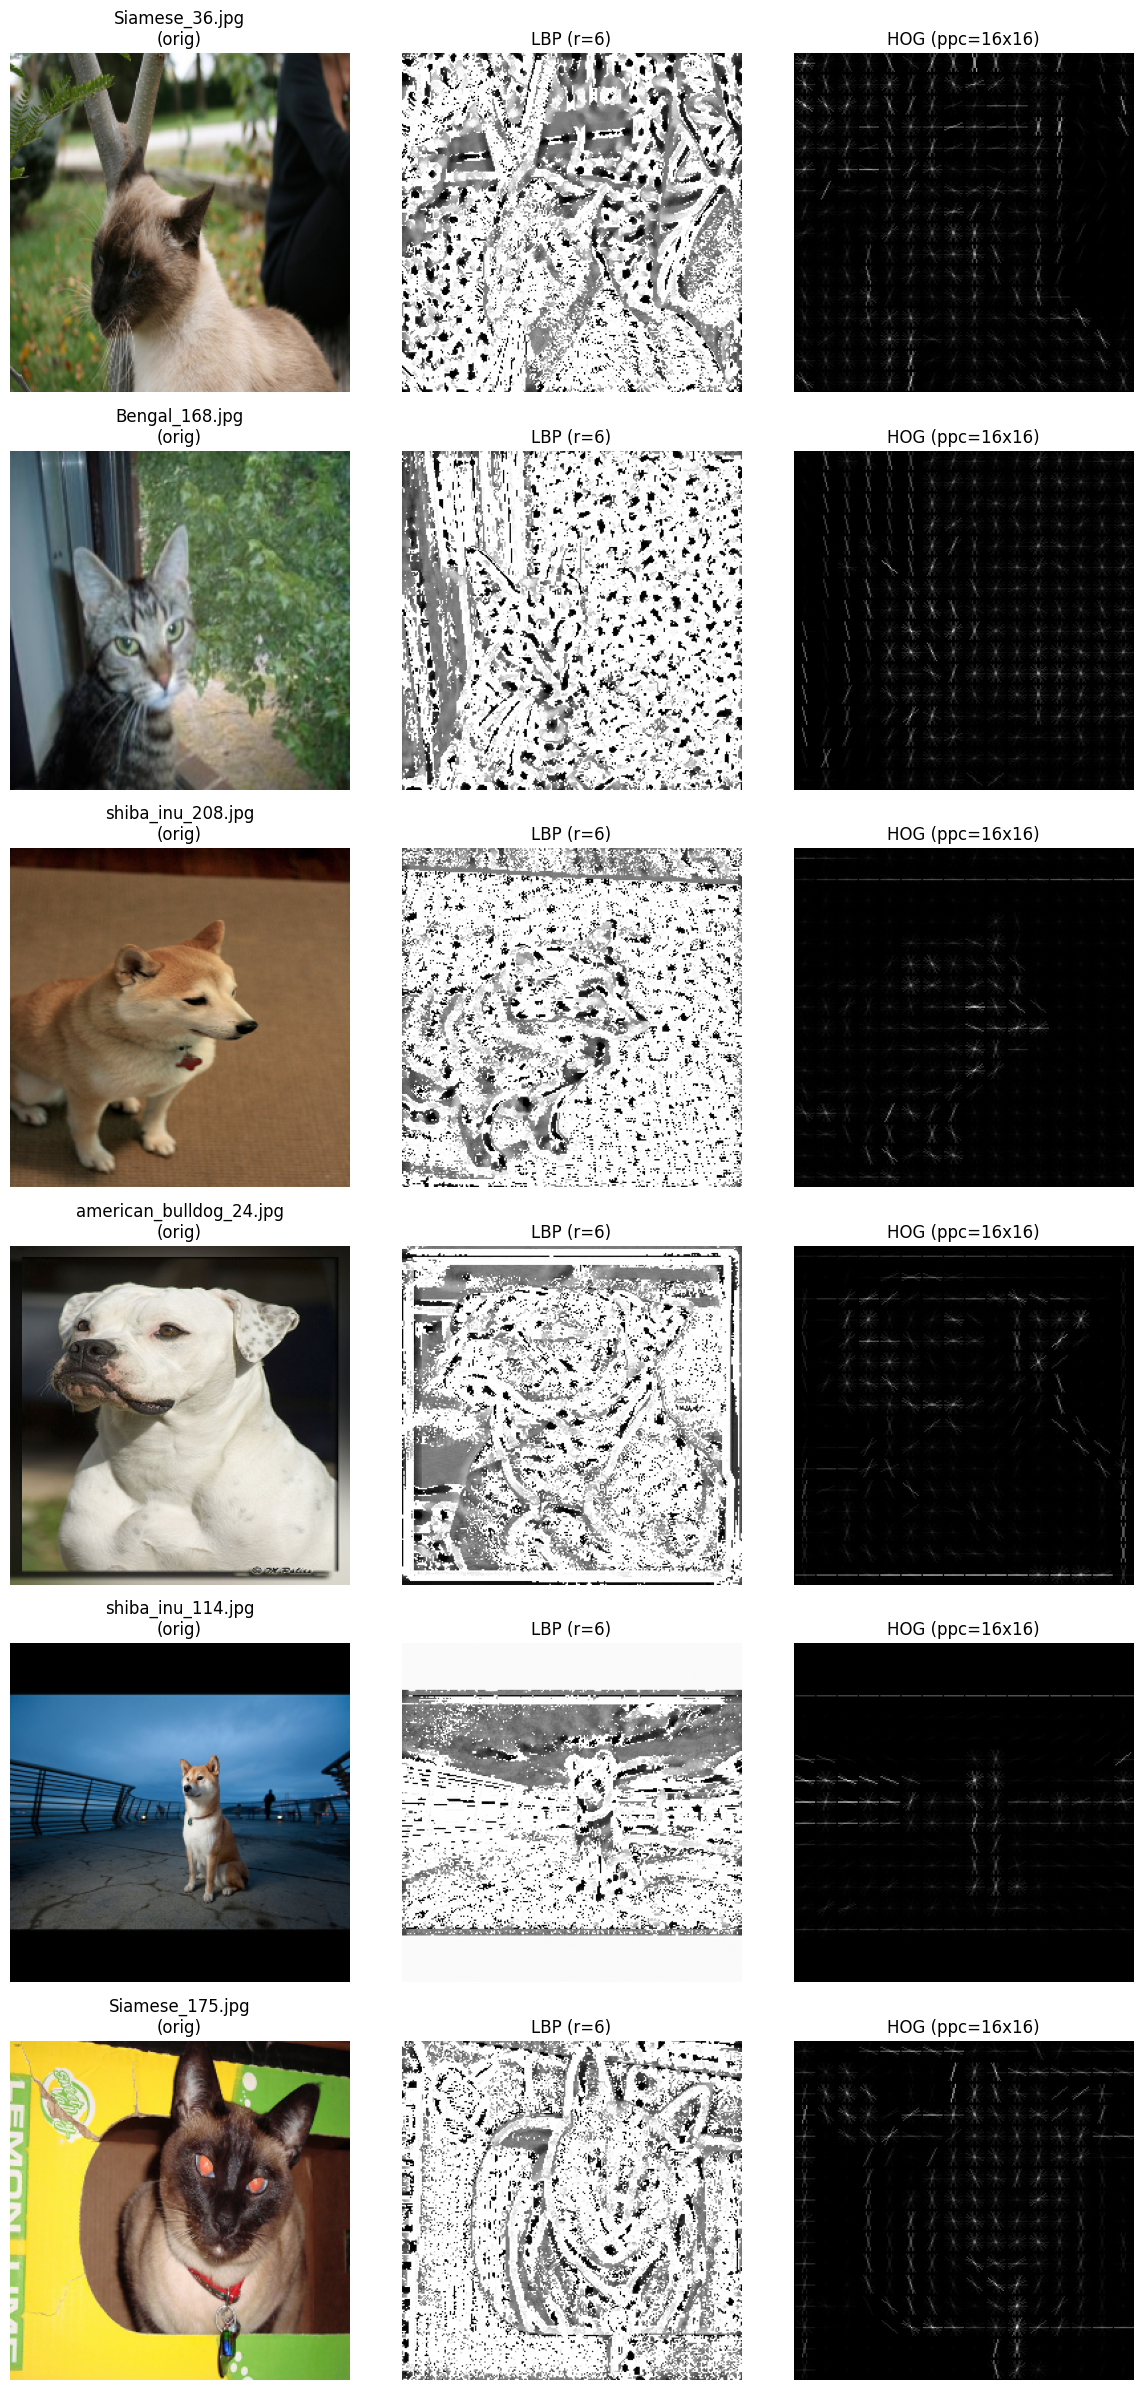

In [ ]:
# -------------- Visualizar algumas imagens + LBP/HOG (amostra) --------------
import random
sample_files = random.sample(files, min(6, len(files)))

fig, axes = plt.subplots(len(sample_files), 3, figsize=(12, 4*len(sample_files)))
for i, fname in enumerate(sample_files):
    path = os.path.join(caminho, fname)
    img_rgb, gray = load_and_preprocess_image(path, size=(256,256))

    # LBP de exemplo (radius 6)
    n_points = 8*6
    lbp = local_binary_pattern(gray, n_points, 6, method='uniform')

    # HOG de exemplo (size 256, ppc 16x16)
    fd, hog_image = hog(gray, orientations=9, pixels_per_cell=(16,16),
                        cells_per_block=(2,2), visualize=True, feature_vector=True)

    ax0 = axes[i,0]
    ax1 = axes[i,1]
    ax2 = axes[i,2]
    ax0.imshow(img_rgb)
    ax0.set_title(f"{fname}\n(orig)")
    ax0.axis('off')
    ax1.imshow(lbp, cmap='gray')
    ax1.set_title("LBP (r=6)")
    ax1.axis('off')
    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title("HOG (ppc=16x16)")
    ax2.axis('off')
plt.tight_layout()


#8) Lista final dos arquivos gerados e instruções para mover para GitHub (Markdown + Código)

In [ ]:
# listar arquivos salvos
generated = sorted([f for f in os.listdir(output_dir) if f.lower().endswith('.csv')])
print(f"Total de CSVs gerados: {len(generated)}")
for fn in generated:
    print(" -", fn)


Total de CSVs gerados: 27
 - hog_128_16x16_noPCA.csv
 - hog_128_16x16_pca75.csv
 - hog_128_16x16_pca90.csv
 - hog_128_32x32_noPCA.csv
 - hog_128_32x32_pca75.csv
 - hog_128_32x32_pca90.csv
 - hog_128_8x8_noPCA.csv
 - hog_128_8x8_pca75.csv
 - hog_128_8x8_pca90.csv
 - hog_256_16x16_noPCA.csv
 - hog_256_16x16_pca75.csv
 - hog_256_16x16_pca90.csv
 - hog_256_32x32_noPCA.csv
 - hog_256_32x32_pca75.csv
 - hog_256_32x32_pca90.csv
 - hog_256_8x8_noPCA.csv
 - hog_256_8x8_pca75.csv
 - hog_256_8x8_pca90.csv
 - lbp_256_r12_multiorientation.csv
 - lbp_256_r12_ror.csv
 - lbp_256_r12_uniform.csv
 - lbp_256_r3_multiorientation.csv
 - lbp_256_r3_ror.csv
 - lbp_256_r3_uniform.csv
 - lbp_256_r6_multiorientation.csv
 - lbp_256_r6_ror.csv
 - lbp_256_r6_uniform.csv


In [ ]:
generated = sorted([f for f in os.listdir(output_dir) if f.lower().endswith('.csv')])
print(f"✅ Total de CSVs gerados: {len(generated)}\n")

for fn in generated:
    csv_path = os.path.join(output_dir, fn)
    try:
        df = pd.read_csv(csv_path)

        # Shape
        n_rows, n_cols = df.shape
        meta_cols = ['filename','animal','label','race']
        feature_cols = [c for c in df.columns if c not in meta_cols]
        n_features = len(feature_cols)

        # Distribuição de classes
        class_counts = df['label'].value_counts().to_dict()

        # Features completamente zeradas
        zero_features_mask = df[feature_cols].sum(axis=0) == 0
        zero_features_list = zero_features_mask[zero_features_mask].index.tolist()
        zero_features_count = len(zero_features_list)

        # Valores faltantes
        f_na = df[feature_cols].isna().sum().sum()

        print(f"📄 {fn}")
        print(f"   - Shape: {n_rows} linhas × {n_cols} colunas")
        print(f"   - Nº de features: {n_features}")
        print(f"   - Distribuição de classes: {class_counts}")
        print(f"   - Nº de features completamente zeradas: {zero_features_count}")
        if zero_features_count > 0:
            print(f"     → Features zeradas: {', '.join(zero_features_list)}")
        print(f"   - Nº de valores NaN: {f_na}")

    except Exception as e:
        print(f"⚠️ Erro ao abrir {fn}: {e}")


✅ Total de CSVs gerados: 27

📄 hog_128_16x16_noPCA.csv
   - Shape: 800 linhas × 1768 colunas
   - Nº de features: 1764
   - Distribuição de classes: {0: 400, 1: 400}
   - Nº de features completamente zeradas: 0
   - Nº de valores NaN: 0
📄 hog_128_16x16_pca75.csv
   - Shape: 800 linhas × 122 colunas
   - Nº de features: 118
   - Distribuição de classes: {0: 400, 1: 400}
   - Nº de features completamente zeradas: 1
     → Features zeradas: pc47
   - Nº de valores NaN: 0
📄 hog_128_16x16_pca90.csv
   - Shape: 800 linhas × 237 colunas
   - Nº de features: 233
   - Distribuição de classes: {0: 400, 1: 400}
   - Nº de features completamente zeradas: 2
     → Features zeradas: pc47, pc224
   - Nº de valores NaN: 0
📄 hog_128_32x32_noPCA.csv
   - Shape: 800 linhas × 328 colunas
   - Nº de features: 324
   - Distribuição de classes: {0: 400, 1: 400}
   - Nº de features completamente zeradas: 0
   - Nº de valores NaN: 0
📄 hog_128_32x32_pca75.csv
   - Shape: 800 linhas × 37 colunas
   - Nº de featu